In [448]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from google.colab import files

ModuleNotFoundError: No module named 'google.colab'

In [414]:
data = pd.read_excel("dataset_compiled.xlsx", parse_dates=['Month'])

In [415]:
data.head()

,Month,Temp °C,pH,DO (mg/L),BOD (mg/L),Total Coli form /100ml
0,Jan-12,14.5,6.86,9.6,2.4,200
1,Feb-12,16,7.68,8.8,2.8,280
2,Mar-12,18,7.42,8.4,2.6,350
3,Apr-12,18,8.32,7.4,2.7,220
4,May-12,19,7.84,8,2.2,200


In [416]:
data.tail()

,Month,Temp °C,pH,DO (mg/L),BOD (mg/L),Total Coli form /100ml
97,Feb-20,18,7.6,10.2,<1,80
98,Mar-20,19,7.13,9.8,<1,50
99,Apr-20,19,7.7,9.8,0.8,60
100,May-20,18,7.85,9.6,1,70
101,Jun-20,22,7.58,9.2,1,60


In [417]:
data.columns = ["month", 'temp', 'pH','DO','BOD','coliform']

In [418]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 6 columns):
month       102 non-null object
temp        97 non-null object
pH          98 non-null object
DO          98 non-null object
BOD         98 non-null object
coliform    98 non-null object
dtypes: object(6)
memory usage: 4.9+ KB


In [419]:
data.replace(to_replace= "-" ,value = np.NAN, inplace = True)
data.replace(to_replace= "<1" , value = .8 , inplace = True)

In [420]:
data.columns
lis = ['temp', 'pH', 'DO', 'BOD', 'coliform']

In [421]:
for i in lis:
    pd.to_numeric(data[i])

In [422]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 6 columns):
month       102 non-null object
temp        83 non-null float64
pH          96 non-null float64
DO          96 non-null float64
BOD         96 non-null float64
coliform    92 non-null float64
dtypes: float64(5), object(1)
memory usage: 4.9+ KB


In [423]:
from datetime import datetime

In [424]:
data['month'].replace(to_replace = "-", value = " ", regex = True, inplace = True)

In [425]:
data['month'] = data['month'].apply(lambda x : datetime.strptime(x, '%b %y'))


In [426]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 6 columns):
month       102 non-null datetime64[ns]
temp        83 non-null float64
pH          96 non-null float64
DO          96 non-null float64
BOD         96 non-null float64
coliform    92 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.9 KB


In [427]:
data.describe()

,temp,pH,DO,BOD,coliform
count,83.000000,96.000000,96.000000,96.000000,92.000000
mean,18.654217,7.781667,9.006250,1.348958,105.173913
std,2.594709,0.349754,0.843278,0.694337,74.648570
min,10.000000,6.860000,6.200000,0.800000,22.000000
25%,17.000000,7.510000,8.400000,0.800000,60.000000
50%,19.000000,7.700000,9.000000,1.000000,80.000000
75%,20.000000,8.050000,9.600000,1.800000,115.000000
max,24.000000,8.500000,10.800000,3.400000,500.000000


In [428]:
data.set_index('month', inplace = True)

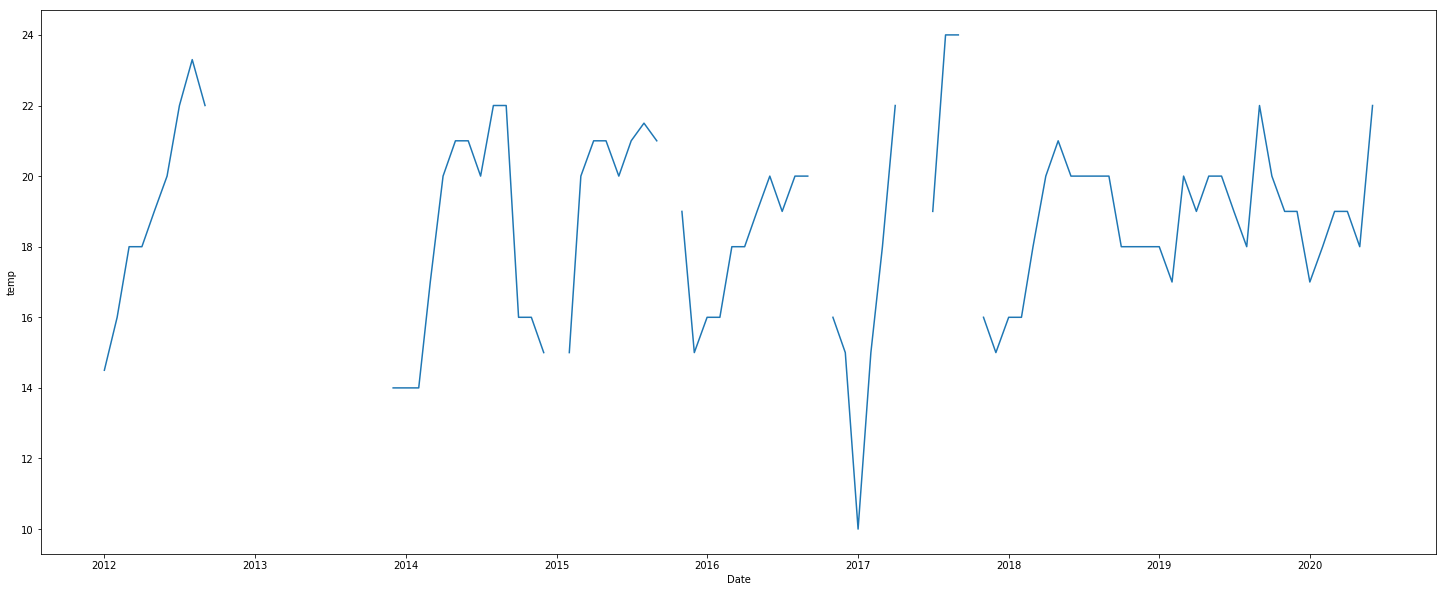

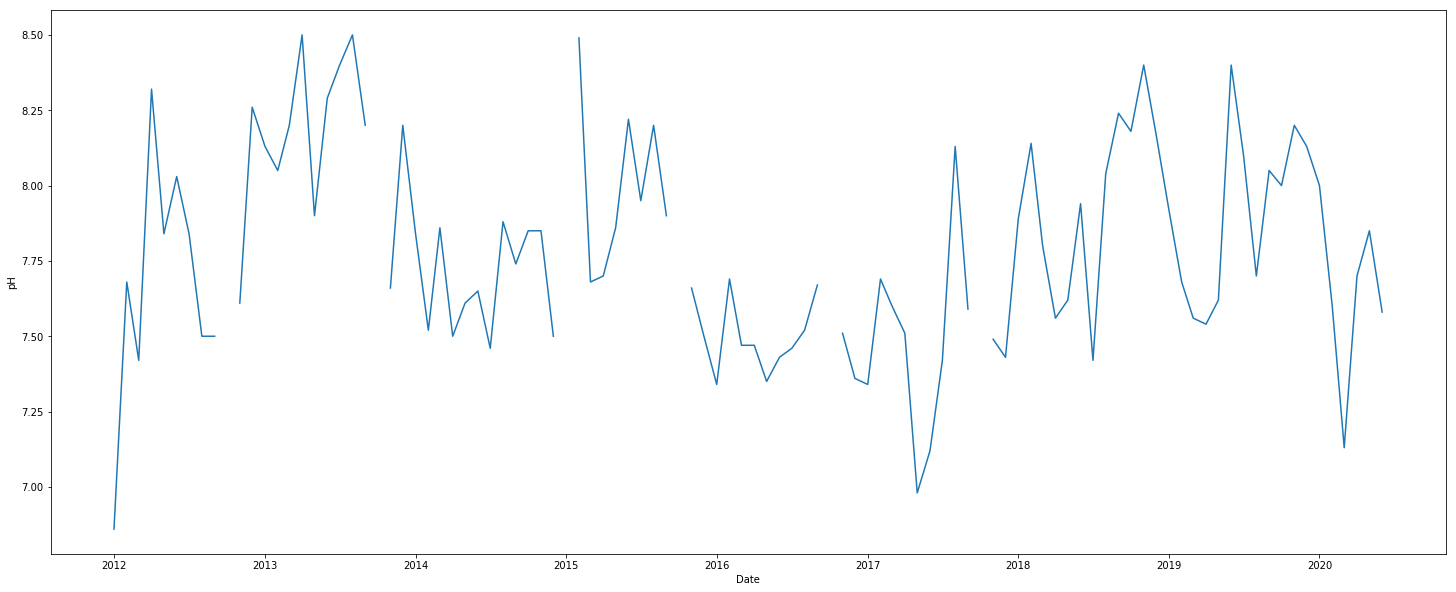

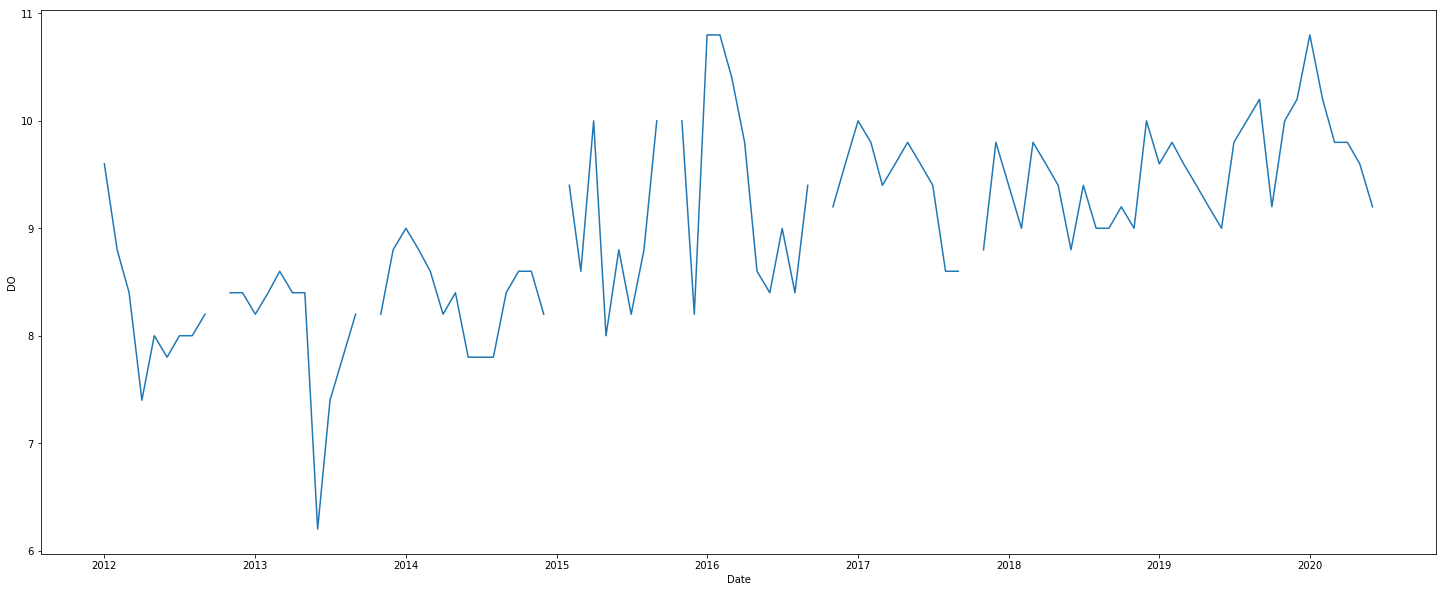

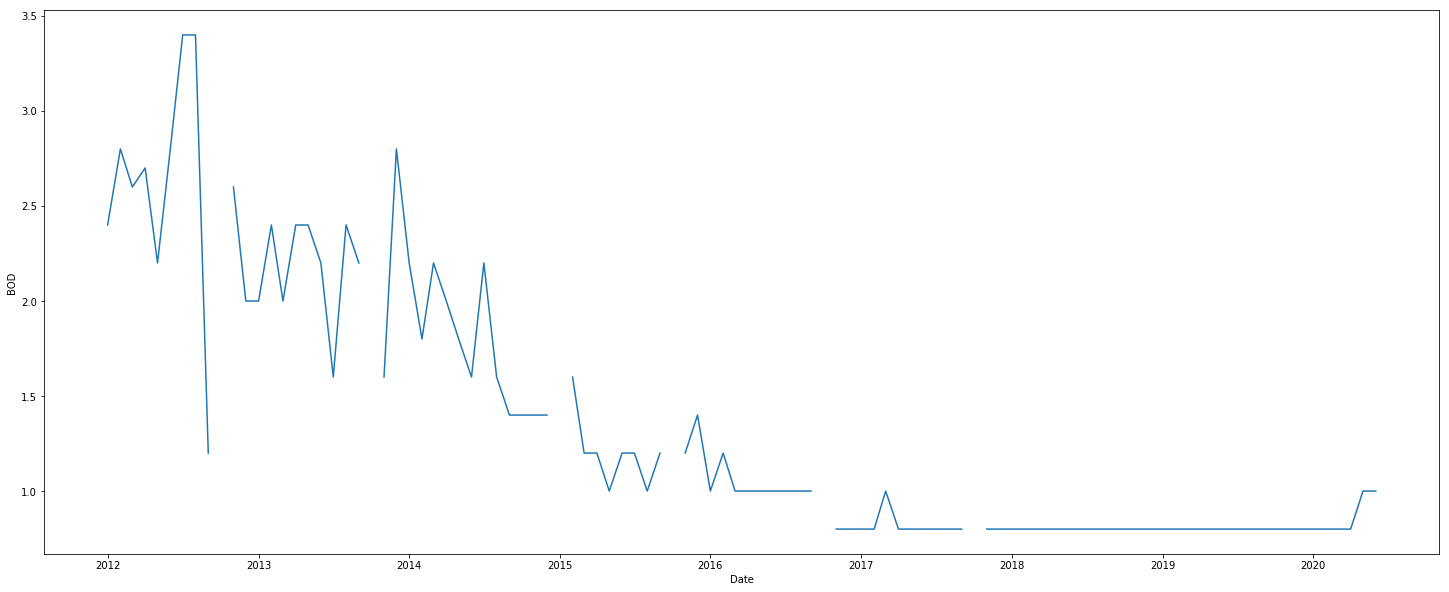

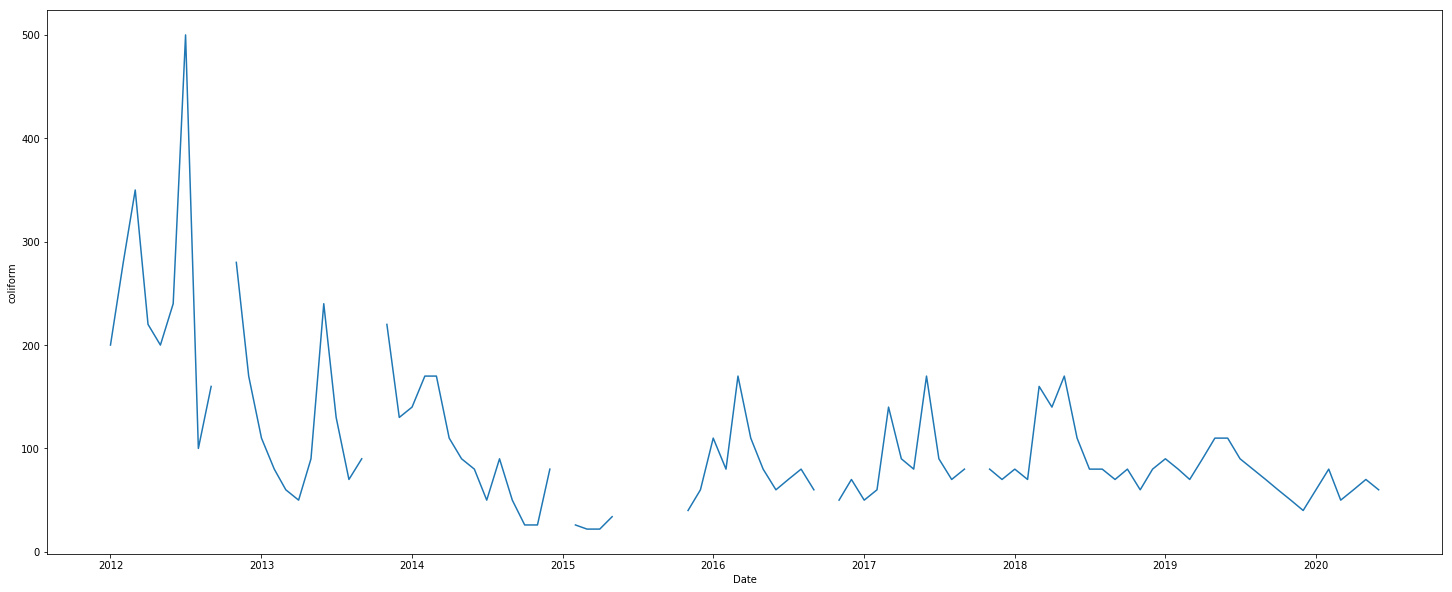

In [429]:
for i in lis:
    plt.figure(figsize=(25, 10))
    plt.plot(data[i])
    plt.ylabel(i)
    plt.xlabel('Date')

Discontinuity is due to missing data fields

In [430]:
dat = (data.isnull().sum()).sort_values(ascending= False)
Missing_Data = pd.DataFrame({'Number of missing values' : dat})
Missing_Data

,Number of missing values
temp,19
coliform,10
BOD,6
DO,6
pH,6


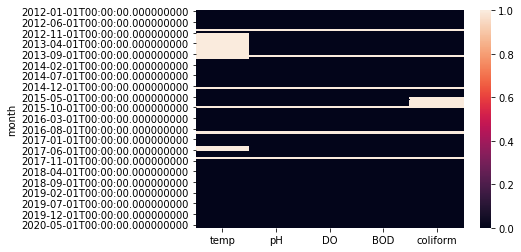

In [431]:
sns.heatmap(data.isnull())

As seen from the heatmap most of the NULL values occur together for all columns, these values can either be deleted entirely or we could use a generalized Last observation carried forward (LOCF) or Next observation carried backward (NOCB) approach

As data seems to have seasonality and trend, therefore imputations cant be made simply by mean/median/mode/linear interpolation methods. Hence, applying seasonal adjustment with linear interpolation to consider trend and seasonality in data

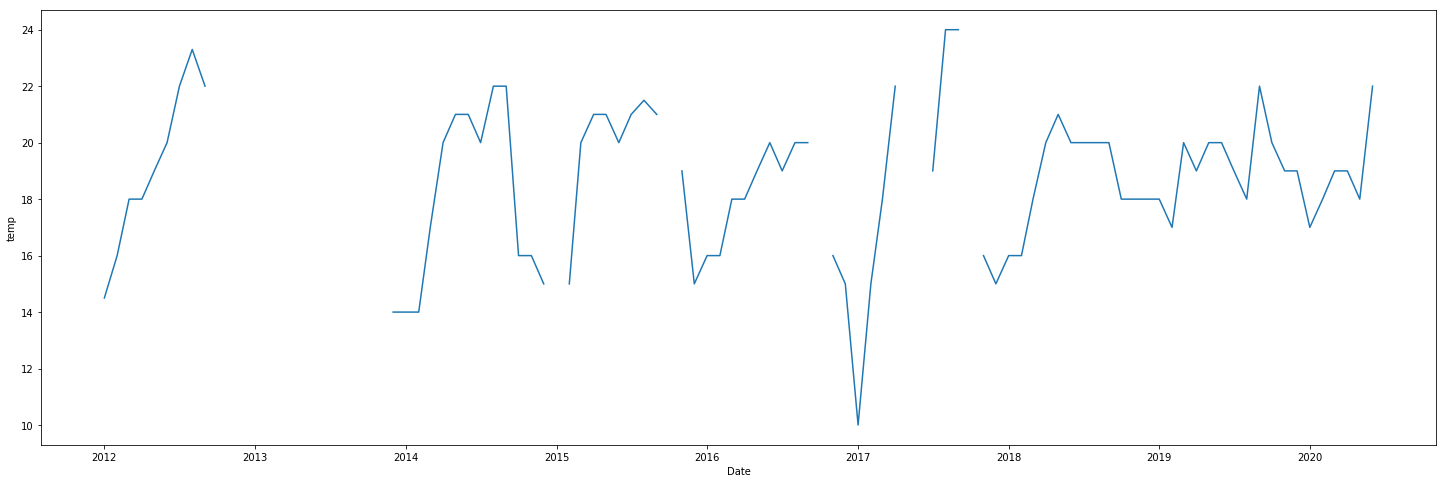

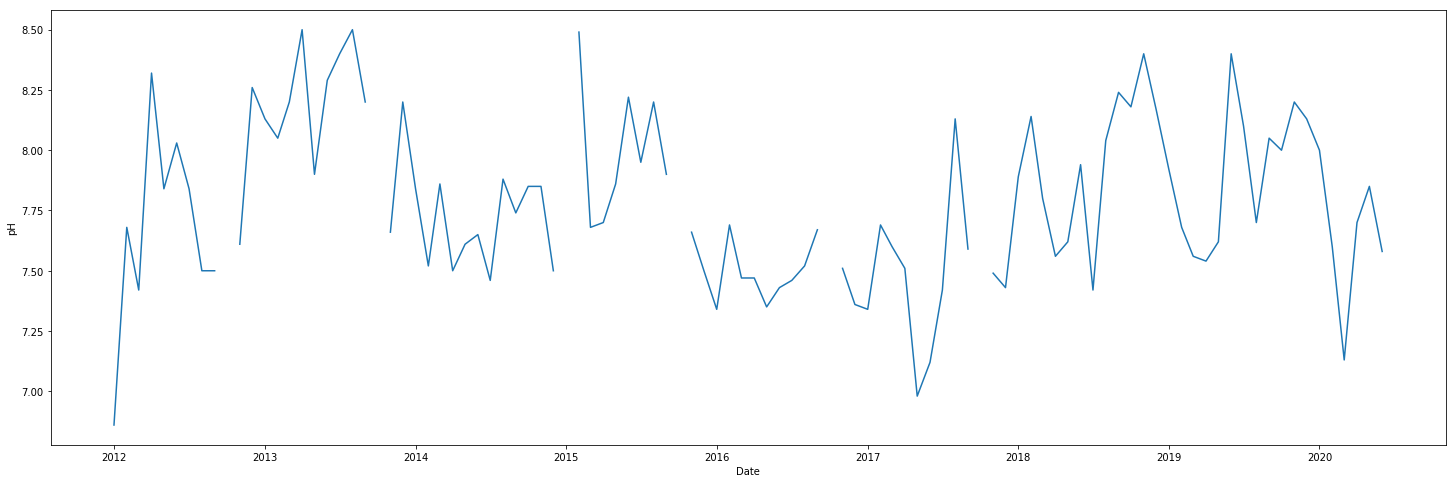

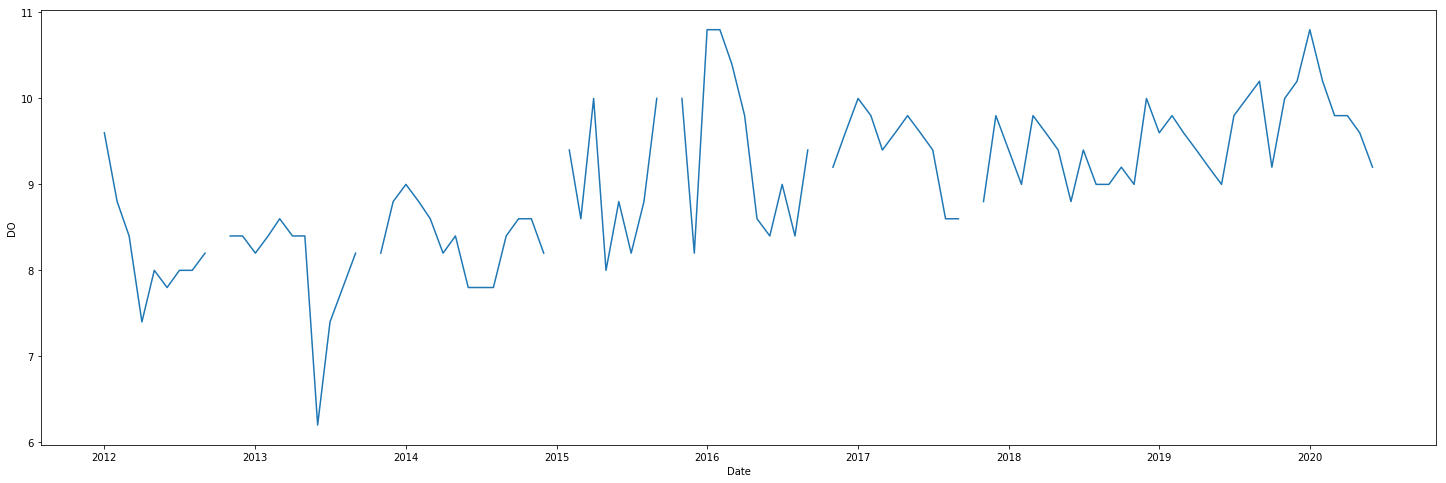

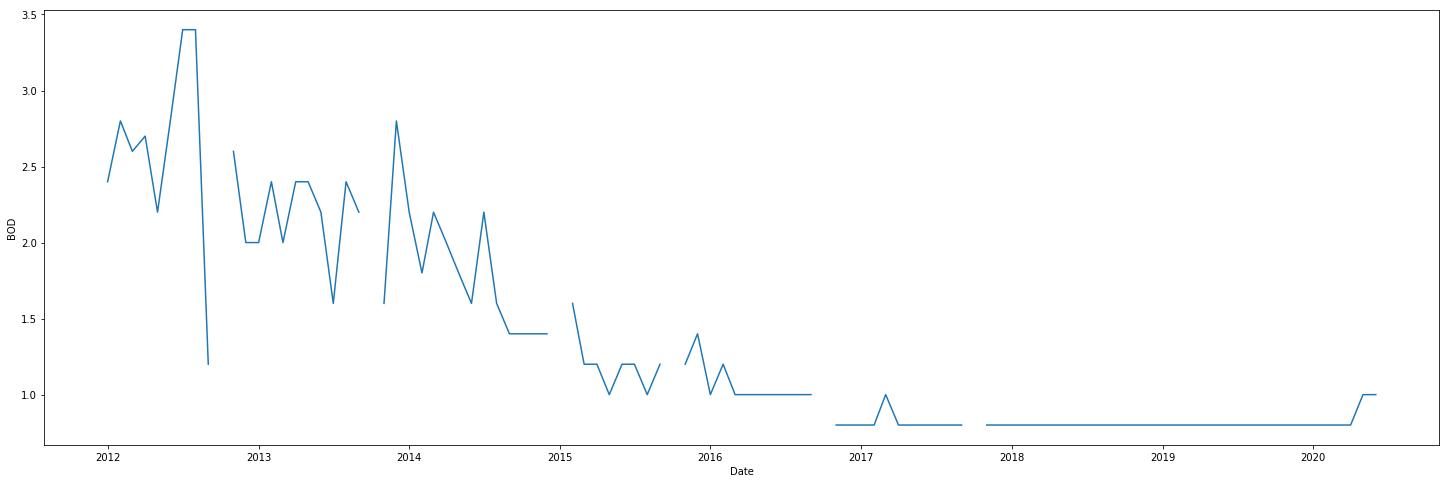

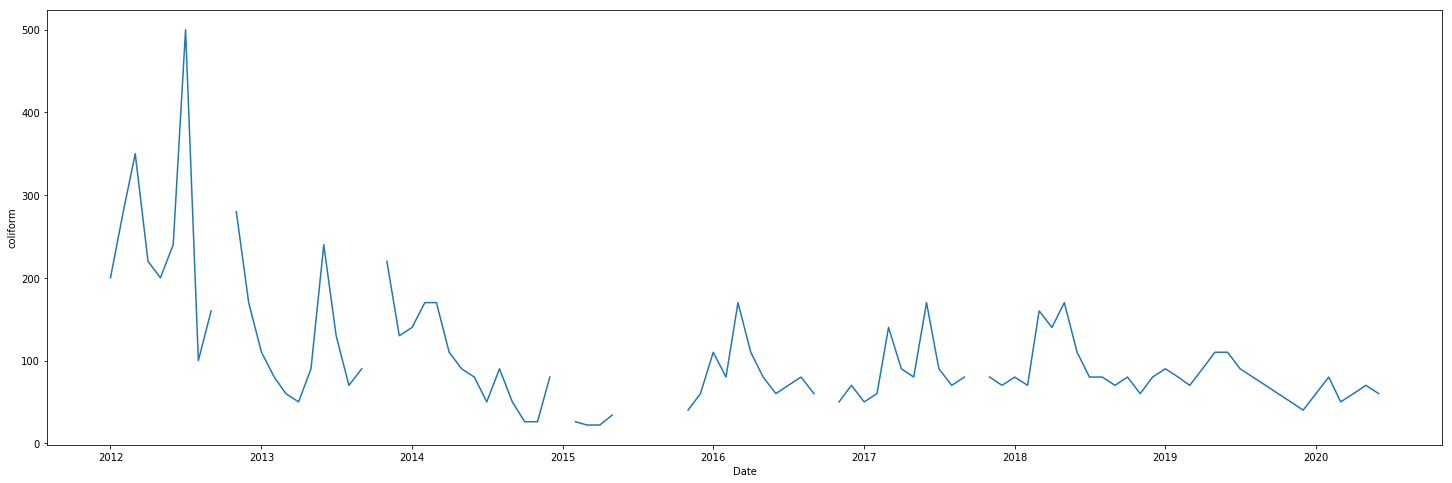

In [432]:
# time interpolation on entire data
data_interpol = data.interpolate(method='time')
for i in lis:
    plt.figure(figsize=(25, 8))
    plt.plot(data[i])
    plt.ylabel(i)
    plt.xlabel('Date')

Values like pH, DO might work better with Forward filling values based on previous values (LOCF)

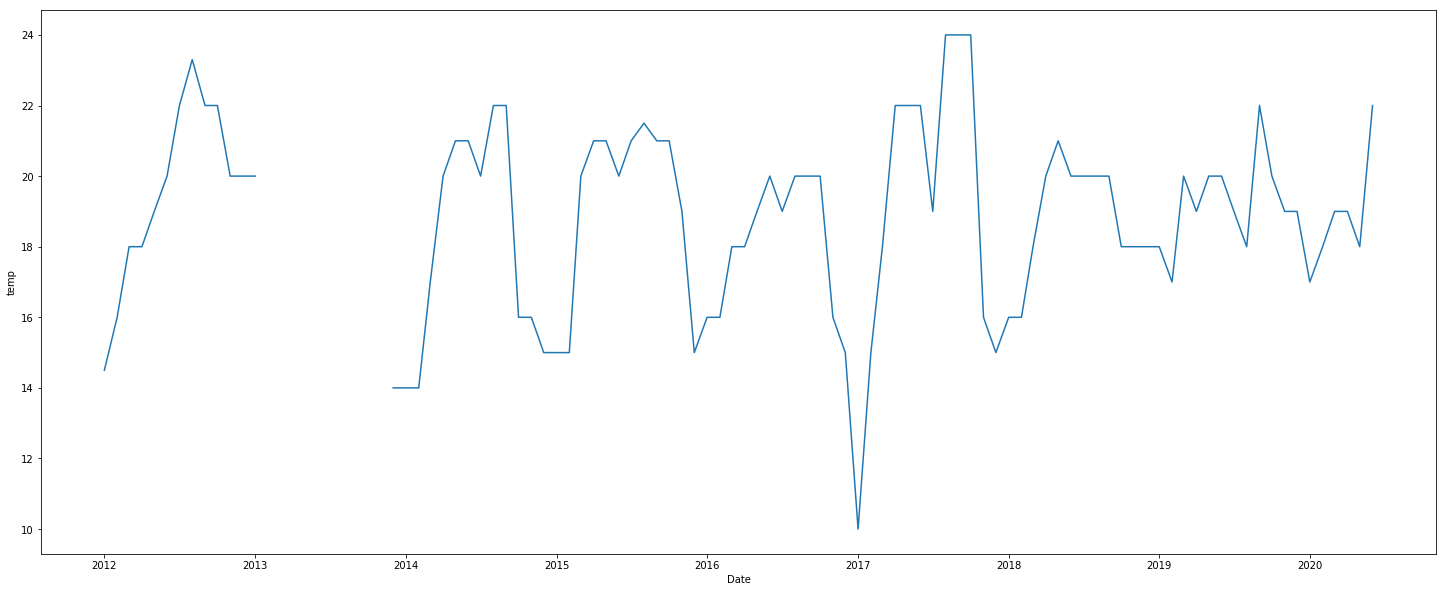

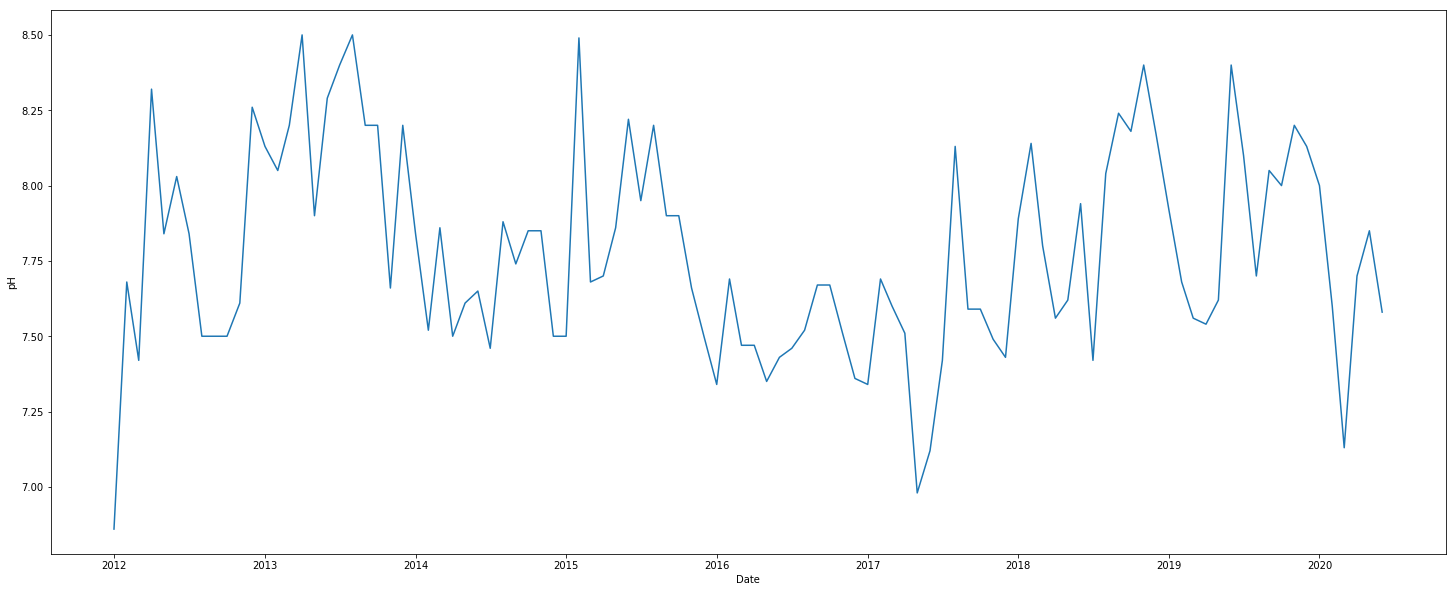

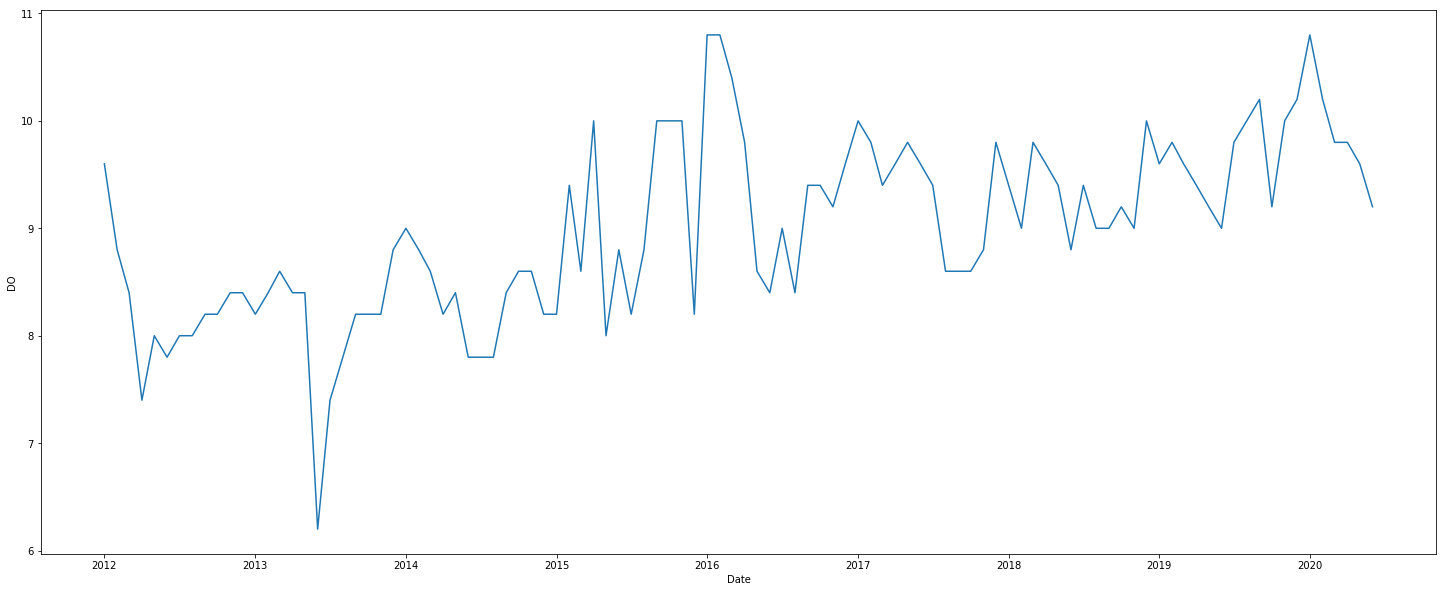

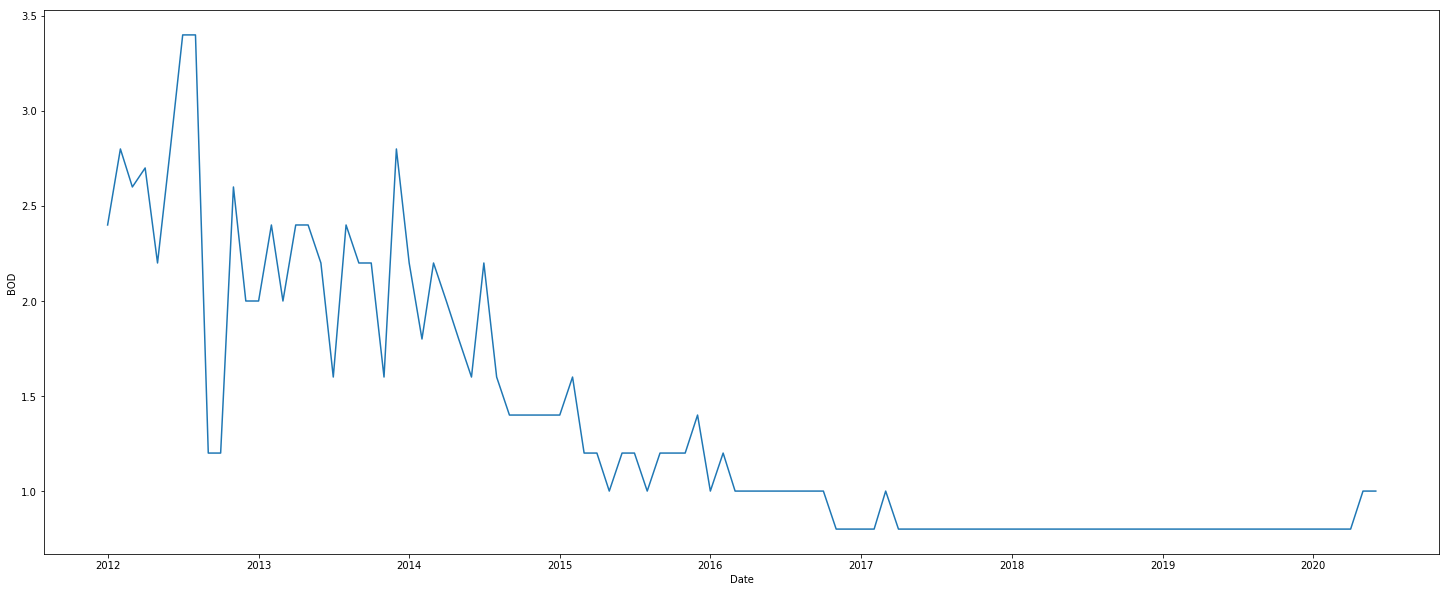

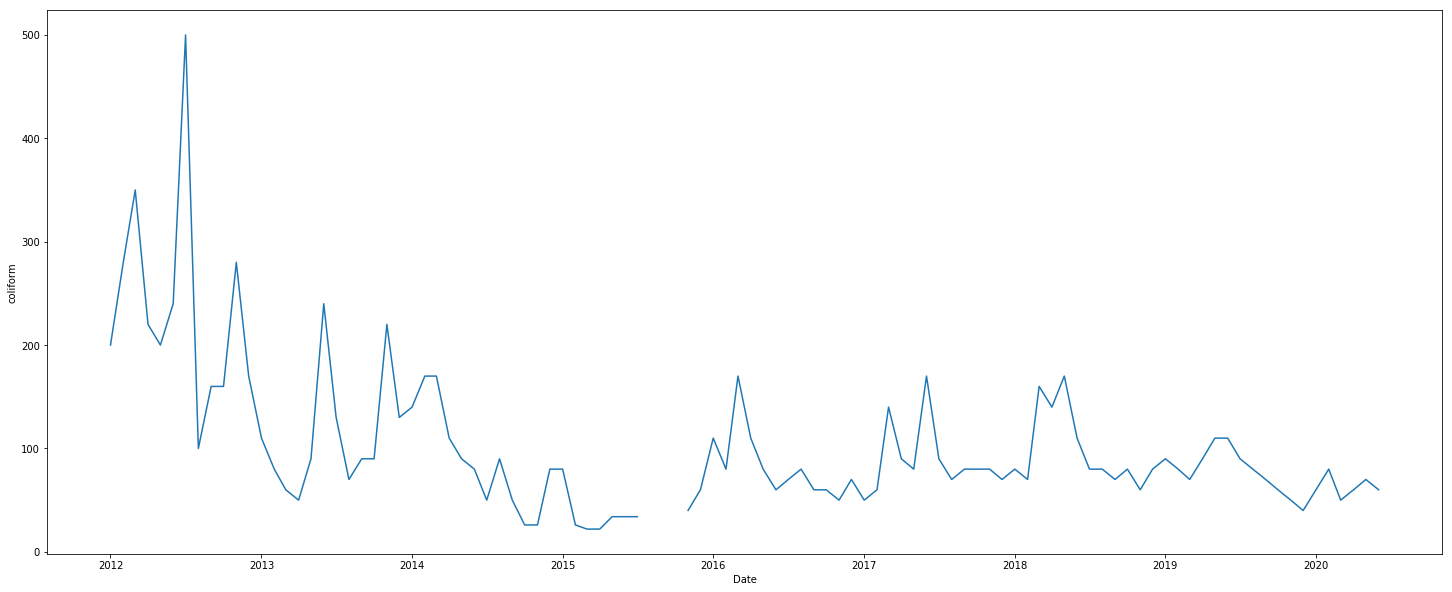

In [433]:
data.ffill(limit = 2, inplace= True)   #(LOCF)
for i in lis:
    plt.figure(figsize=(25, 10))
    plt.plot(data[i])
    plt.ylabel(i)
    plt.xlabel('Date')

In [434]:
data.isnull().sum()

temp        10
pH           0
DO           0
BOD          0
coliform     3
dtype: int64

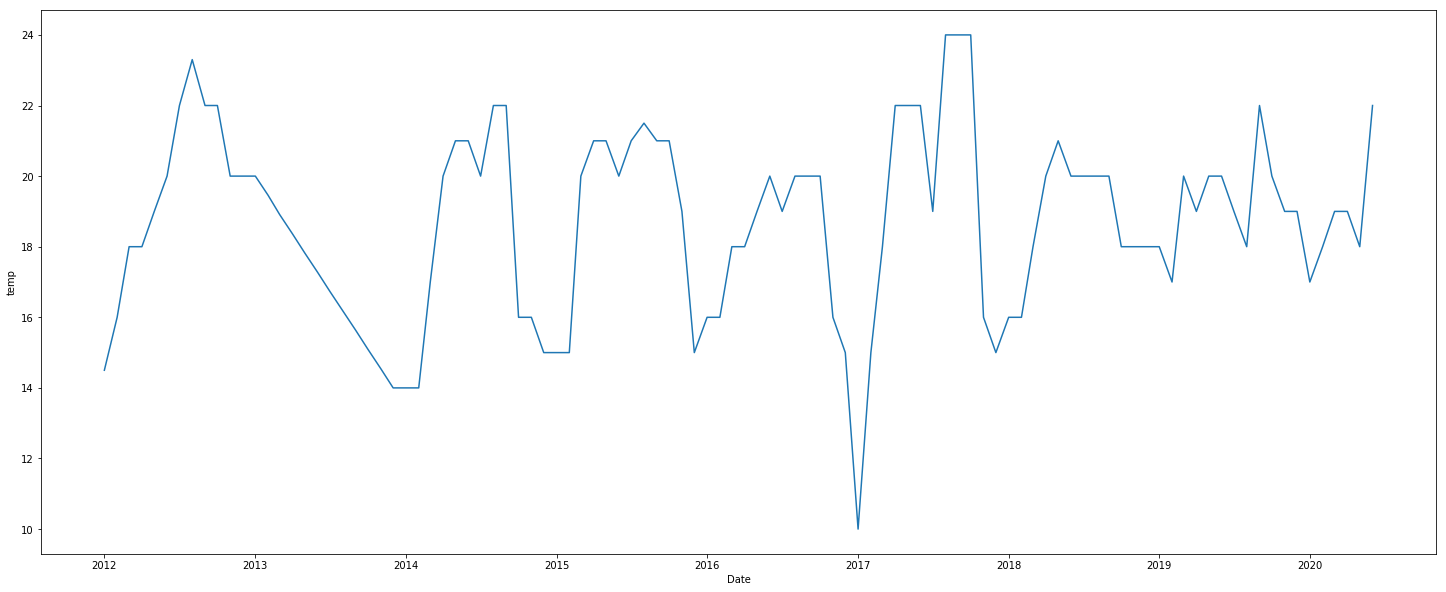

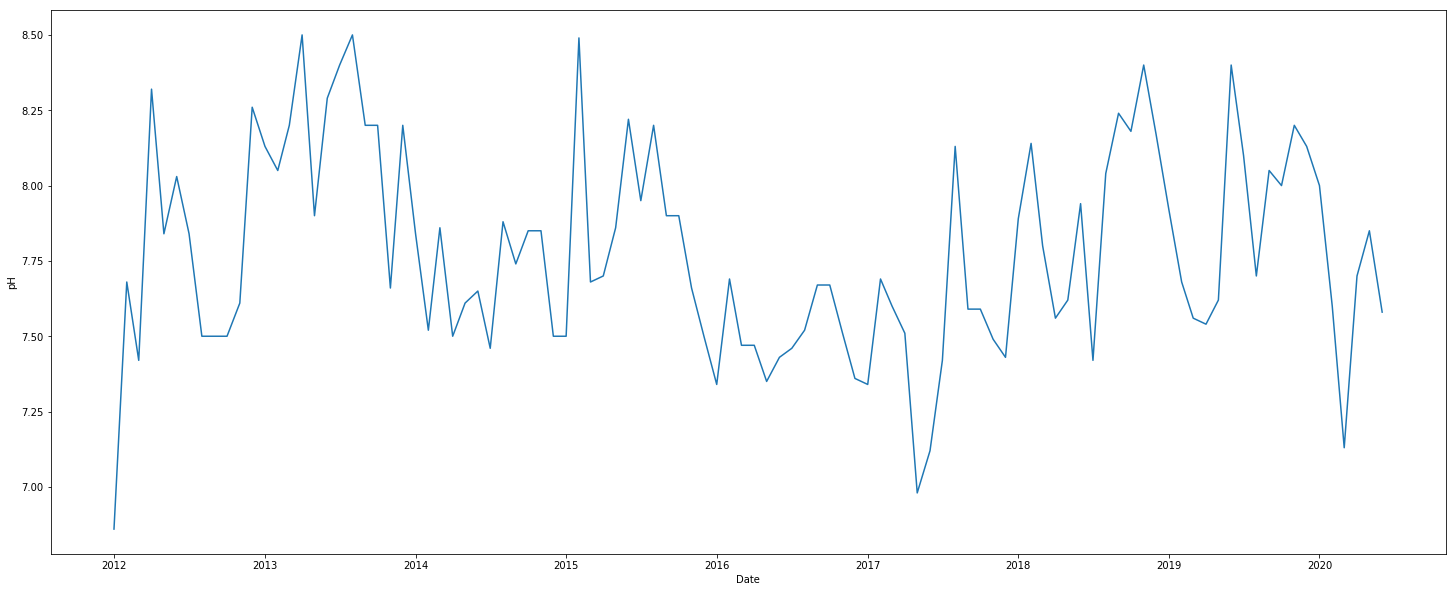

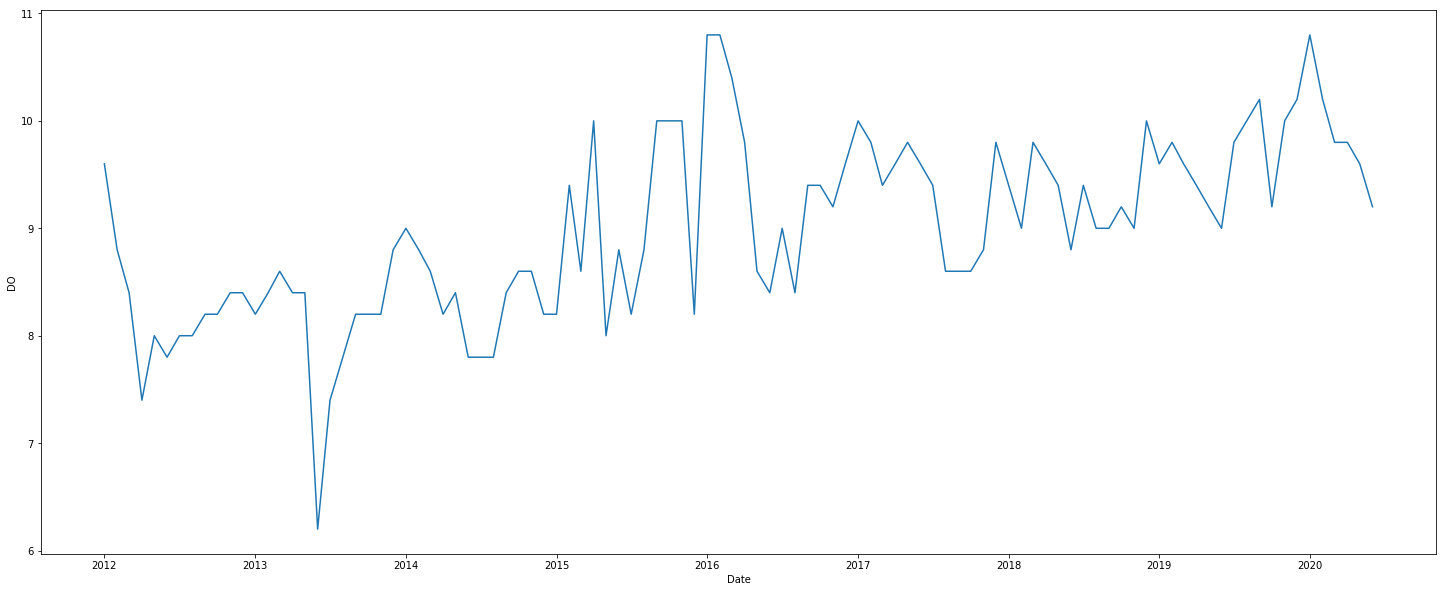

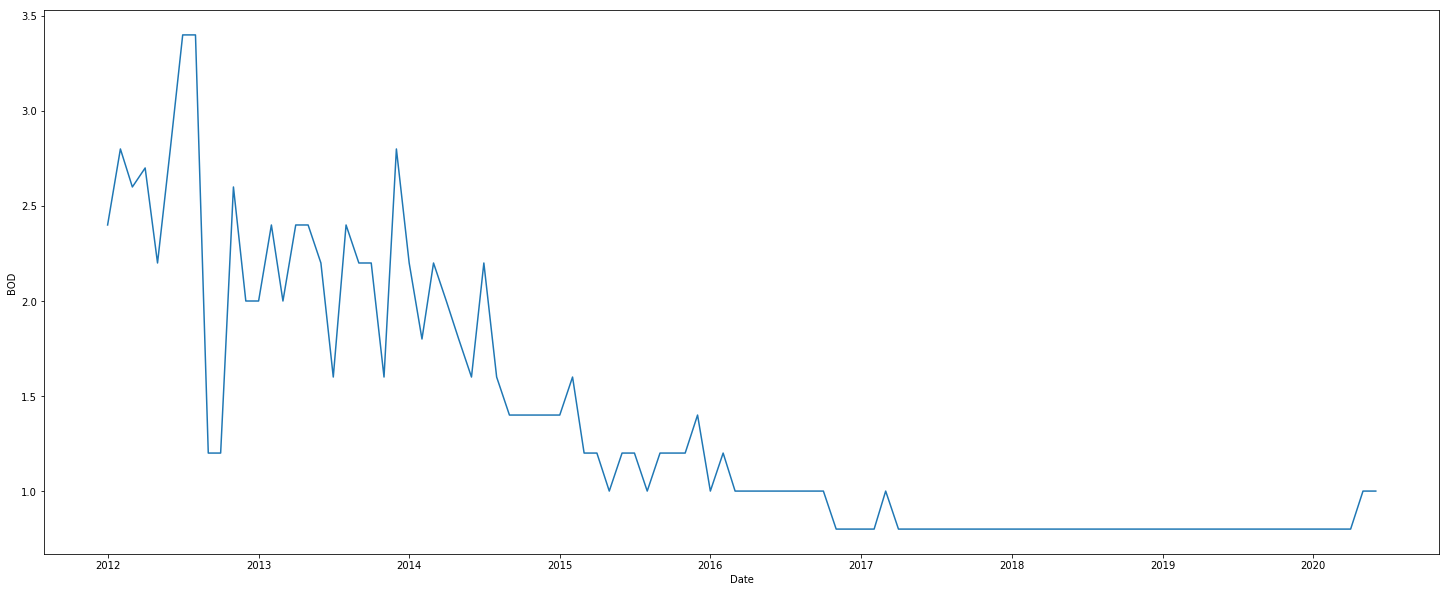

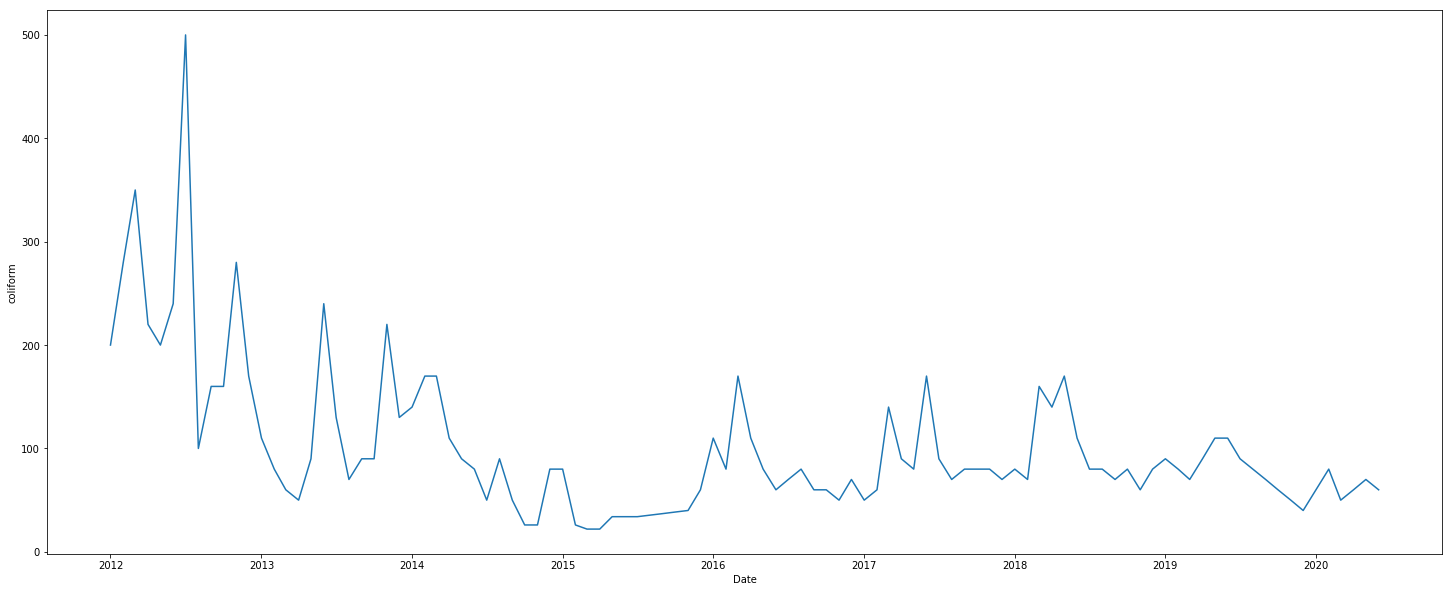

In [435]:
# Applying interpolation to left values 
data = data.interpolate(method='linear')
for i in lis:
    plt.figure(figsize=(25, 10))
    plt.plot(data[i])
    plt.ylabel(i)
    plt.xlabel('Date')

Finding correlation between features

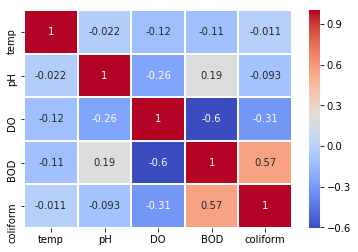

In [436]:
sns.heatmap(data.corr(),annot=True, linewidths=1 ,cmap= 'coolwarm')

Not very high correlation. BOD and coliform count slightly correlated as expected.

Stationarity tests on interpolated and LOCF data

- Dickey Fuller 

In [437]:
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(values):
    result=adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Time series has a unit root, indicating it is non-stationary ")

In [438]:
for i in lis:
    print(i)
    adfuller_test(data[i])

temp
ADF Test Statistic : -5.1220028200153305
p-value : 1.2658971153111362e-05
#Lags Used : 6
Number of Observations Used : 95
Reject the null hypothesis. Data has no unit root and is stationary
pH
ADF Test Statistic : -6.184647947649455
p-value : 6.332434137801655e-08
#Lags Used : 0
Number of Observations Used : 101
Reject the null hypothesis. Data has no unit root and is stationary
DO
ADF Test Statistic : -0.7391596006082386
p-value : 0.8363439616808066
#Lags Used : 11
Number of Observations Used : 90
Time series has a unit root, indicating it is non-stationary 
BOD
ADF Test Statistic : -1.3265821057456495
p-value : 0.6169249424797141
#Lags Used : 11
Number of Observations Used : 90
Time series has a unit root, indicating it is non-stationary 
coliform
ADF Test Statistic : -5.1502550376178355
p-value : 1.1098701331858304e-05
#Lags Used : 0
Number of Observations Used : 101
Reject the null hypothesis. Data has no unit root and is stationary


Time series corresponding to BOD and DO are highly non stationary

- KPSS test

In [439]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [440]:
for i in lis:
    print(i)
    kpss_test(data[i])

temp
Results of KPSS Test:
Test Statistic            0.144157
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
pH
Results of KPSS Test:
Test Statistic            0.12126
p-value                   0.10000
Lags Used                13.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64
DO
Results of KPSS Test:
Test Statistic            0.678341
p-value                   0.015514
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
BOD
Results of KPSS Test:
Test Statistic            0.746927
p-value                   0.010000
Lags Used                13.000000
Critical Value (10%

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Gives same results as ADF test, however shows that coliform series is just stationary

In [442]:
#Checking tests for data imputed using temporal imputations 
for i in lis:
    print(i)
    adfuller_test(data_interpol[i])


temp
ADF Test Statistic : -3.1908124354072678
p-value : 0.020522689033408318
#Lags Used : 13
Number of Observations Used : 88
Reject the null hypothesis. Data has no unit root and is stationary
pH
ADF Test Statistic : -6.028039238708796
p-value : 1.4401186341957008e-07
#Lags Used : 0
Number of Observations Used : 101
Reject the null hypothesis. Data has no unit root and is stationary
DO
ADF Test Statistic : -0.69501516996273
p-value : 0.8480364994570898
#Lags Used : 11
Number of Observations Used : 90
Time series has a unit root, indicating it is non-stationary 
BOD
ADF Test Statistic : -2.056479426200866
p-value : 0.2623704732549881
#Lags Used : 10
Number of Observations Used : 91
Time series has a unit root, indicating it is non-stationary 
coliform
ADF Test Statistic : -4.063306389713602
p-value : 0.0011129889161364567
#Lags Used : 10
Number of Observations Used : 91
Reject the null hypothesis. Data has no unit root and is stationary


Same results. Using LOCF imputed data for further analysis

#### Autocorrelation plots and pacf plots

<Figure size 864x576 with 0 Axes>

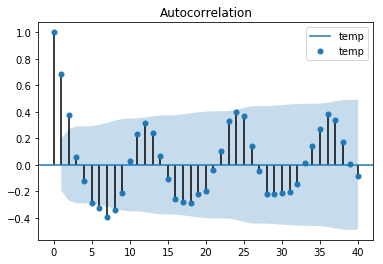

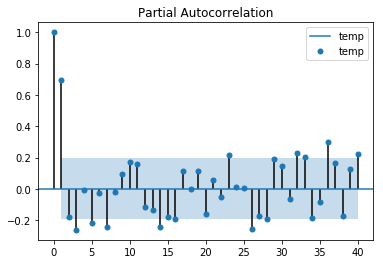

<Figure size 864x576 with 0 Axes>

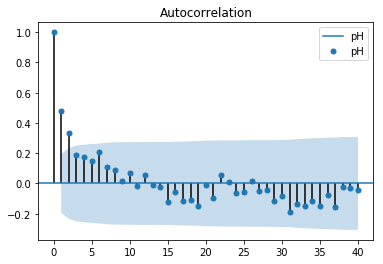

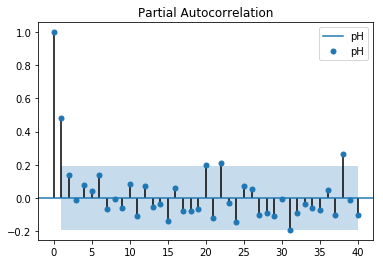

<Figure size 864x576 with 0 Axes>

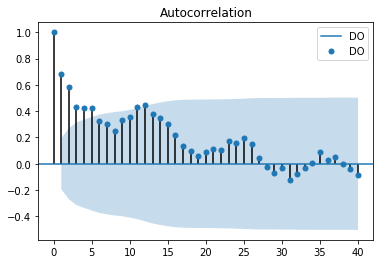

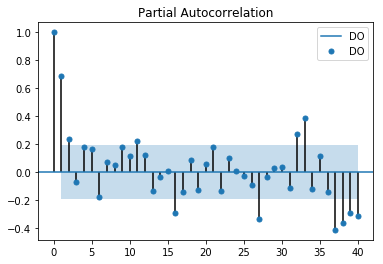

<Figure size 864x576 with 0 Axes>

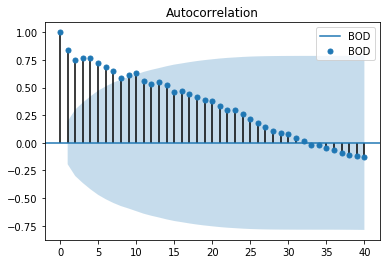

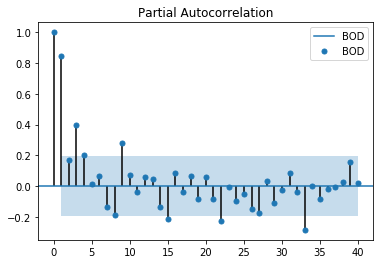

<Figure size 864x576 with 0 Axes>

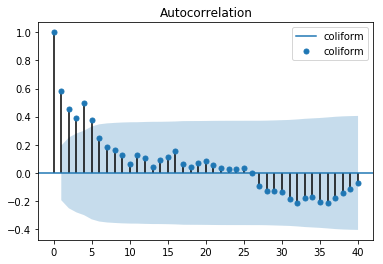

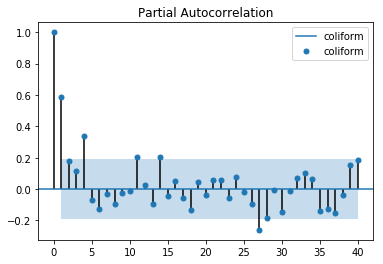

In [464]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
for i in lis:
    fig = plt.figure(figsize=(12,8))
    fig = plot_acf(data[i],lags=40, label = i)
    plt.legend(loc='best')
    fig = plot_pacf(data[i],lags=40, label = i)
    plt.legend(loc='best')

No obvious seasonality except in the case of temperature

#### Persistent model

In [453]:
from math import sqrt
def persistence(train, test , label):
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # make prediction
        predictions.append(history[-1]) #persistence based on one day prior predictions
        # observation
        history.append(test[i])
     # line plot of observed vs predicted
    plt.plot(test, label = 'test')
    plt.plot(predictions , label = 'predictions')
    plt.title(label)
    plt.legend(loc = 'best')
    plt.show()
    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    r2 = r2_score(test,predictions)
    print('RMSE: %.3f' % rmse)
    print('R2 score : %.3f' %r2)

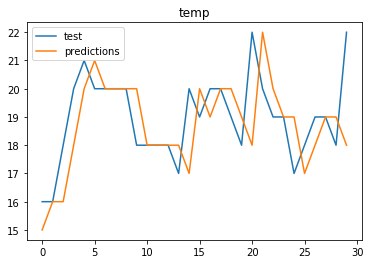

RMSE: 1.560
R2 score : -0.124


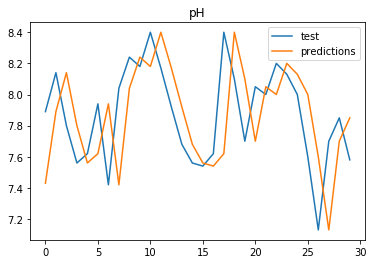

RMSE: 0.334
R2 score : -0.227


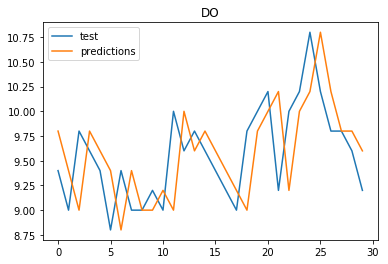

RMSE: 0.477
R2 score : -0.068


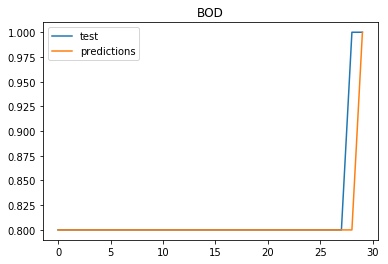

RMSE: 0.037
R2 score : 0.464


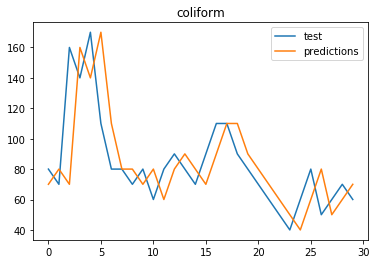

RMSE: 25.232
R2 score : 0.284


In [454]:
for i in lis:
    X = data[i].values
    train, test = X[:-30], X[-30:] #(70-30 split)
    persistence(train,test,i)

#### Sarima Model

In [476]:
import statsmodels.api as sm
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(start_params=[0, 0, 0, 1],disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


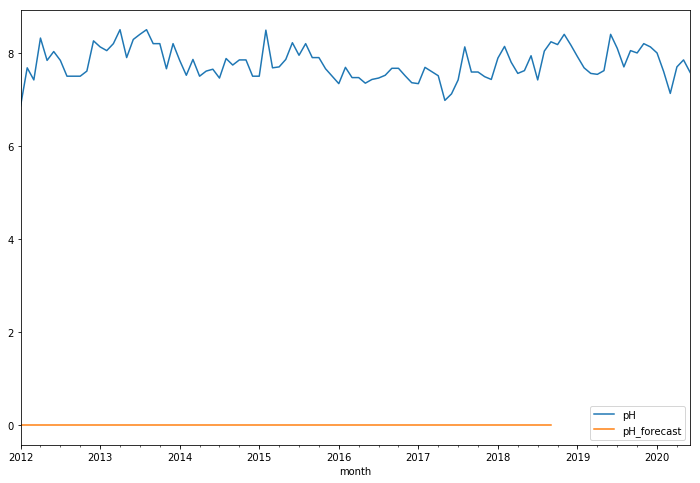

In [477]:
model=sm.tsa.statespace.SARIMAX(data['pH'],order=(2, 0, 0),seasonal_order=(0,0,0,0)) #parameters set by using acf and pacf curves
results=model.fit()
data['pH_forecast']=results.predict(start=0,end=80,dynamic=True)
data[['pH','pH_forecast']].plot(figsize=(12,8))